# Two Layer QG Model Example #

Here is a quick overview of how to use the two-layer model. See the
:py:class:`pyqg.QGModel` api documentation for further details.

First import numpy, matplotlib, and pyqg:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pyqg

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 19 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 19 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 19 days


## Initialize and Run the Model ##

Here we set up a model which will run for 10 years and start averaging
after 5 years. There are lots of parameters that can be specified as
keyword arguments but we are just using the defaults.

In [2]:
year = 24*60*60*360.
m = pyqg.QGModel(tmax=10*year, twrite=10000, tavestart=0*year)
m.run()

t=        72000000, tc=     10000: cfl=0.120789, ke=0.000484036
t=       144000000, tc=     20000: cfl=0.086632, ke=0.000500989
t=       216000000, tc=     30000: cfl=0.101711, ke=0.000528581
t=       288000000, tc=     40000: cfl=0.086567, ke=0.000516469


## Visualize Output ##


We access the actual pv values through the attribute ``m.q``. The first axis
of ``q`` corresponds with the layer number. (Remeber that in python, numbering
starts at 0.)

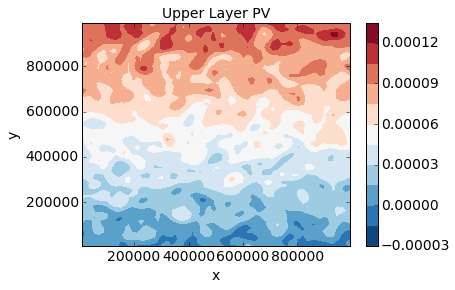

In [3]:
q_upper = m.q[0] + m.Qy[0]*m.y
plt.contourf(m.x, m.y, q_upper, 12, cmap='RdBu_r')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Upper Layer PV')
plt.colorbar();

## Plot Diagnostics ##

The model automatically accumulates averages of certain diagnostics. We can 
find out what diagnostics are available by calling

In [4]:
m.describe_diagnostics()

NAME       | DESCRIPTION
--------------------------------------------------------------------------------
APEflux    | spectral flux of available potential energy           
APEgen     | total APE generation                                  
APEgenspec | spectrum of APE generation                            
EKE        | mean eddy kinetic energy                              
EKEdiss    | total energy dissipation by bottom drag               
Ensspec    | enstrophy spectrum                                    
KEflux     | spectral flux of kinetic energy                       
KEspec     |  kinetic energy spectrum                              
entspec    | barotropic enstrophy spectrum                         
q          | QGPV                                                  


In [33]:
def spec_error(E,sn):
    """
       Calculates the spectral error associated with a given
         spectral estimate assuming large sn
         
       E is the spectral estimate
       sn is the number of realizations used in the average"""
    
    std_E = (1/np.sqrt(sn))
    El = E/(1 + 2*std_E)
    Eu = E/(1 - 2*std_E)
    return El, Eu, std_E

In [58]:
sn = m.diagnostics['KEspec']['count']

Note that "sn" is not the total of independent realization. We calculating the averages every time-step starting at tavestart. A measure of this decorrelation timescale is the eddy turn-over time scale Te. The number of independent realizations is then sn/(sn*dt/Te) 

In [92]:
ens = .5*m.H1 * m.spec_var(m.wv2*m.ph[0]) + \
                 .5*m.H2 * m.spec_var(m.wv2*m.ph[1])
    
Teddy = 2.*np.pi*np.sqrt( m.H / ens )
Teddy/86400

Teddy/m.dt

653.06524514533498

In [93]:
kespec_u = m.get_diagnostic('KEspec')[0].sum(axis=0)
kespec_l = m.get_diagnostic('KEspec')[1].sum(axis=0)

In [98]:
KEspec_u_El, KEspec_u_Eu,_ = spec_error(kespec_u,sn/(sn*m.dt/Teddy))
KEspec_l_El, KEspec_l_Eu,_ = spec_error(kespec_l,sn/(sn*m.dt/Teddy))

To look at the wavenumber energy spectrum, we plot the `KEspec` diagnostic.
(Note that summing along the l-axis, as in this example, does not give us
a true *isotropic* wavenumber spectrum.)

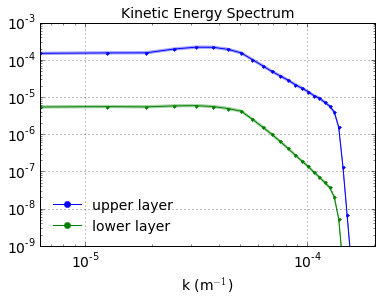

In [100]:
plt.fill_between( m.kk ,KEspec_u_El, KEspec_u_Eu, color='b', alpha=0.25)
plt.fill_between( m.kk ,KEspec_l_El, KEspec_l_Eu, color='g', alpha=0.25)

plt.loglog( m.kk, kespec_u, 'b.-' )
plt.loglog( m.kk, kespec_l, 'g.-' )

plt.legend(['upper layer','lower layer'], loc='lower left')
plt.ylim([1e-9,1e-3]); plt.xlim([m.kk.min(), m.kk.max()])
plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
plt.title('Kinetic Energy Spectrum');

We can also plot the spectral fluxes of energy.

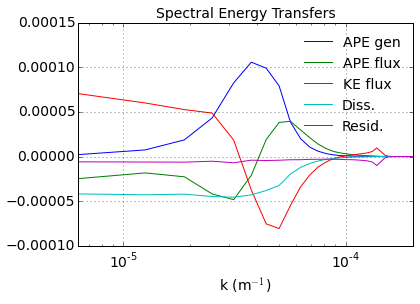

In [6]:
ebud = [ m.get_diagnostic('APEgenspec').sum(axis=0),
         m.get_diagnostic('APEflux').sum(axis=0),
         m.get_diagnostic('KEflux').sum(axis=0),
         -m.rek*m.del2*m.get_diagnostic('KEspec')[1].sum(axis=0)*m.M**2 ]
ebud.append(-np.vstack(ebud).sum(axis=0))
ebud_labels = ['APE gen','APE flux','KE flux','Diss.','Resid.']
[plt.semilogx(m.kk, term) for term in ebud]
plt.legend(ebud_labels, loc='upper right')
plt.xlim([m.kk.min(), m.kk.max()])
plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
plt.title('Spectral Energy Transfers');